In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm
from copy import deepcopy 
from scipy.signal import welch
from colorsys import hls_to_rgb
from joblib import Parallel, delayed, cpu_count

%config InlineBackend.figure_format = 'retina'

### Модель Курамато

In [2]:
class Kuramoto_model:
    def __init__(self, t_k, dt, K=1, N=500, scale=1, freq=10, sim_type="first"):
        self.K = K 
        self.N = N
        self.dt = dt
        self.sigma = scale
        self.T = np.arange(0, t_k, dt)
        self.N_time_points =len(self.T) 
        self.phi_0 = np.random.uniform(-np.pi, np.pi, size=self.N)
        
        if sim_type=="second":
            self.W = self.W_second
        elif sim_type=="first":
            self.W = lambda t: np.random.uniform(0.75*freq, 1.25*freq, size=self.N)
        else:
            raise NotImplementedError 
            
    def W_second(self, t):
        
        w_freq = [np.random.uniform(0.75*_freq, 1.25*_freq, size=self.N) for _freq in [10, 20, 25, 10]]
        return w_freq[0]*(0 < t <= 15) + w_freq[1] * (15 < t <= 30) + w_freq[2] * (30 < t <= 45) + w_freq[3] * (45 < t <= 60)
    
    def get_phases(self):
        
        phases = np.zeros((self.N_time_points, self.N))
        phases[0, :] = self.phi_0
        
        for i_t, t in list(enumerate(self.T))[1:]:
            
            internal = 2 * np.pi * self.W(t)
            delta = np.sin(deepcopy(phases[i_t-1, :]) - phases[i_t-1, :][np.newaxis, :])
            external = self.K / self.N * np.sum(delta, axis=1)
            phases[i_t, :] = phases[i_t-1, :] + self.dt*(internal + external + np.random.normal(0, self.sigma))
            
        return phases
    
    
    def get_signal(self, plot=False):
        phases = self.get_phases()
        complex_signal = np.exp(1j*phases)
        model_signal = complex_signal.mean(axis=1)
        model_real = model_signal.real
        signal = model_real
        if plot:
            plt.figure(figsize=(20, 5))
            plt.plot(self.T, signal)
            plt.xlabel('Time, s')
            plt.ylabel('Amplitude')
            plt.title('Result singnal')       
        return signal 

### Вспомогательные функции:

In [11]:
#------------Functions for exercises -------------------
def run_experiment(info):
    """
    Run experiment, return psd, freqs, signal
    """
    
    f, sim_type = info
    dt=0.01
    k = Kuramoto_model(t_k=60, dt=dt, K=1.5, N=500, scale=1, freq=f, sim_type=sim_type)
    signal = k.get_signal()
    freqs, psd = welch(signal, fs=int(1/dt), scaling="spectrum")
    return psd, freqs, signal

def run_experiment_phases(info):
    """
    Run experiment, return phases
    """
    
    f, sim_type = info
    dt=0.01
    k = Kuramoto_model(t_k=60, dt=dt, K=1.5, N=500, scale=1, freq=f, sim_type=sim_type)
    phase = k.get_phases()
    return phase

def get_plv(phases):
    """
    Calculate PLV between signals
    """
    x = np.exp(1j * np.array(phases))
    x = np.mean(x, axis=-1)
    y = np.conj(x)
    x /= np.abs(x)
    y /= np.abs(y)
    return (x @ y.T)/x.shape[1]

def get_colormap_matrix(signal, window=100, dt=0.01):
    """
    Split signal into windows and stack psds calculated for eah window
    """
    splited = np.split(signal, len(signal)/window)
    n_windows = len(splited)
    print(f"Number of windows: {n_windows}")
    color_map = np.array([welch(split, fs=int(1/dt), scaling="spectrum", nperseg=len(split))[1] for split in splited]).T
    return color_map

#------------Plot-functions-------------------

def plot_psd(freqs, psds, fs=16):
    """
    Plot Power Spectral Density 
    """
    plt.figure(figsize=(10, 6))
    plt.semilogy(freqs, psds)
    plt.title('Power Spectral Density', fontsize=fs)
    plt.xlabel('Frequency', fontsize=fs)
    plt.ylabel('Power', fontsize=fs)
    
def colorize(z):
    """
    Color complex numbers
    """
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s)
    c = np.array(c)
    c = c.swapaxes(0, 2) 
    return c

def plot_PLV(phases, fs=16):
    """
    Plot PLV matrix
    """
    img = colorize(get_plv(phases))
    plt.figure(figsize=(10, 10))
    plt.imshow(img, alpha=0.8)
    plt.xlabel('Signals 1, 2, ..20', fontsize=fs)
    plt.ylabel('Signals 1, 2, ..20', fontsize=fs)
    
def plot_colormap(color_map, fs=16):
    """
    Plot colormap of given 2d array 
    """
    plt.figure(figsize=(20, 10))
    sns.heatmap(color_map, cmap="Blues")
    plt.xlabel('Time, s', fontsize=fs)
    plt.ylabel('Frequency', fontsize=fs)
    plt.show()

## Анализ 

### 1.

### Эксперимент 1:

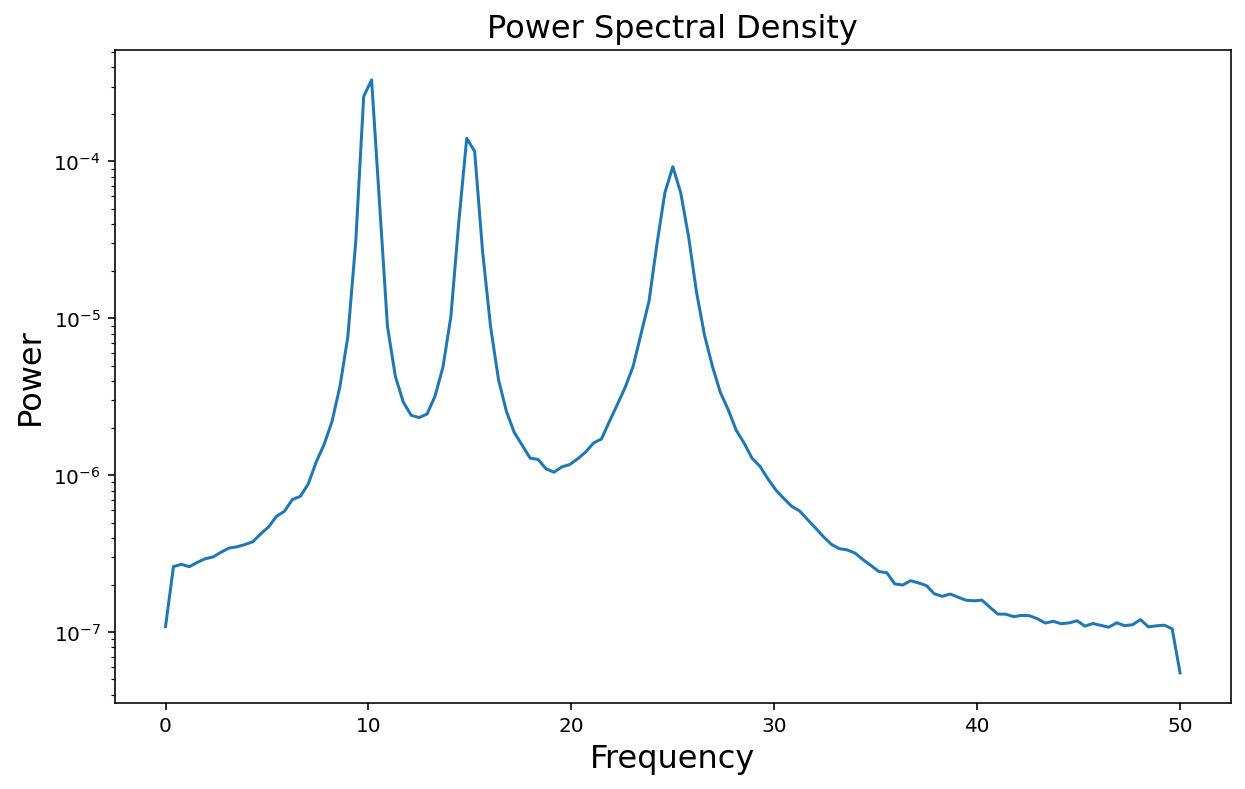

In [4]:
freqs = [10]*10 + [15]*5 + [25]*5

with Parallel(cpu_count()) as pool:
    res = pool(delayed(run_experiment)((f, "first")) for f in tqdm(freqs, leave=False, position=0, desc="Experiment"))  
    
plot_psd(np.mean([x[1] for x in res], axis=0), np.mean([x[0] for x in res], axis=0))

* Результирующий сигнал - усреднение 20 сигналов с частотами 10, 15 и 25. Именно на этих частотах наблюдаются ярко выраженные пики.

### Эксперимент 2:

In [5]:
N_experiments = 50
with Parallel(cpu_count()) as pool:
    res = pool(delayed(run_experiment)((10, "second")) for f in tqdm(range(N_experiments), leave=False, position=0, desc="Experiment"))

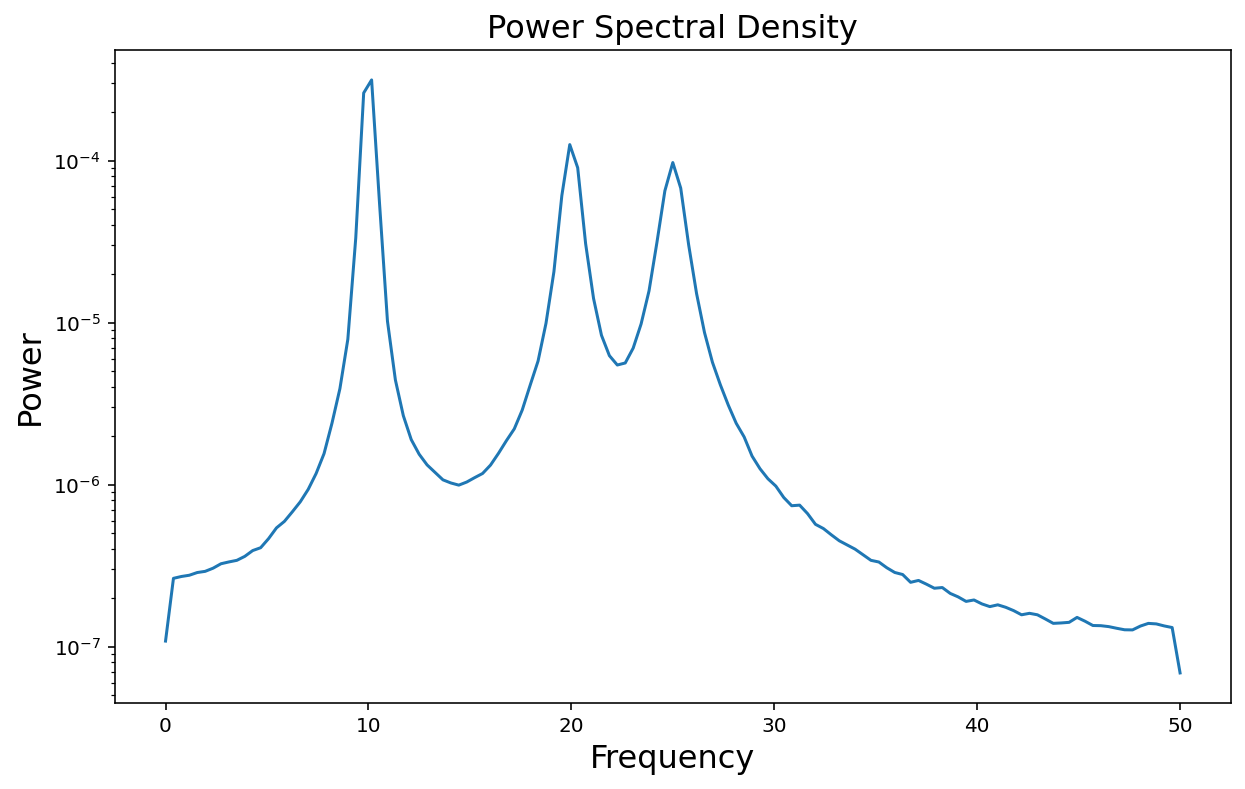

In [6]:
plot_psd(np.mean([x[1] for x in res], axis=0), np.mean([x[0] for x in res], axis=0))

* Собственная частота осциляторов в зависимости от времени принимает значения: 10, 20 и 25. Именно на этих частотах наблюдаются ярко выраженные пики.

### 2.

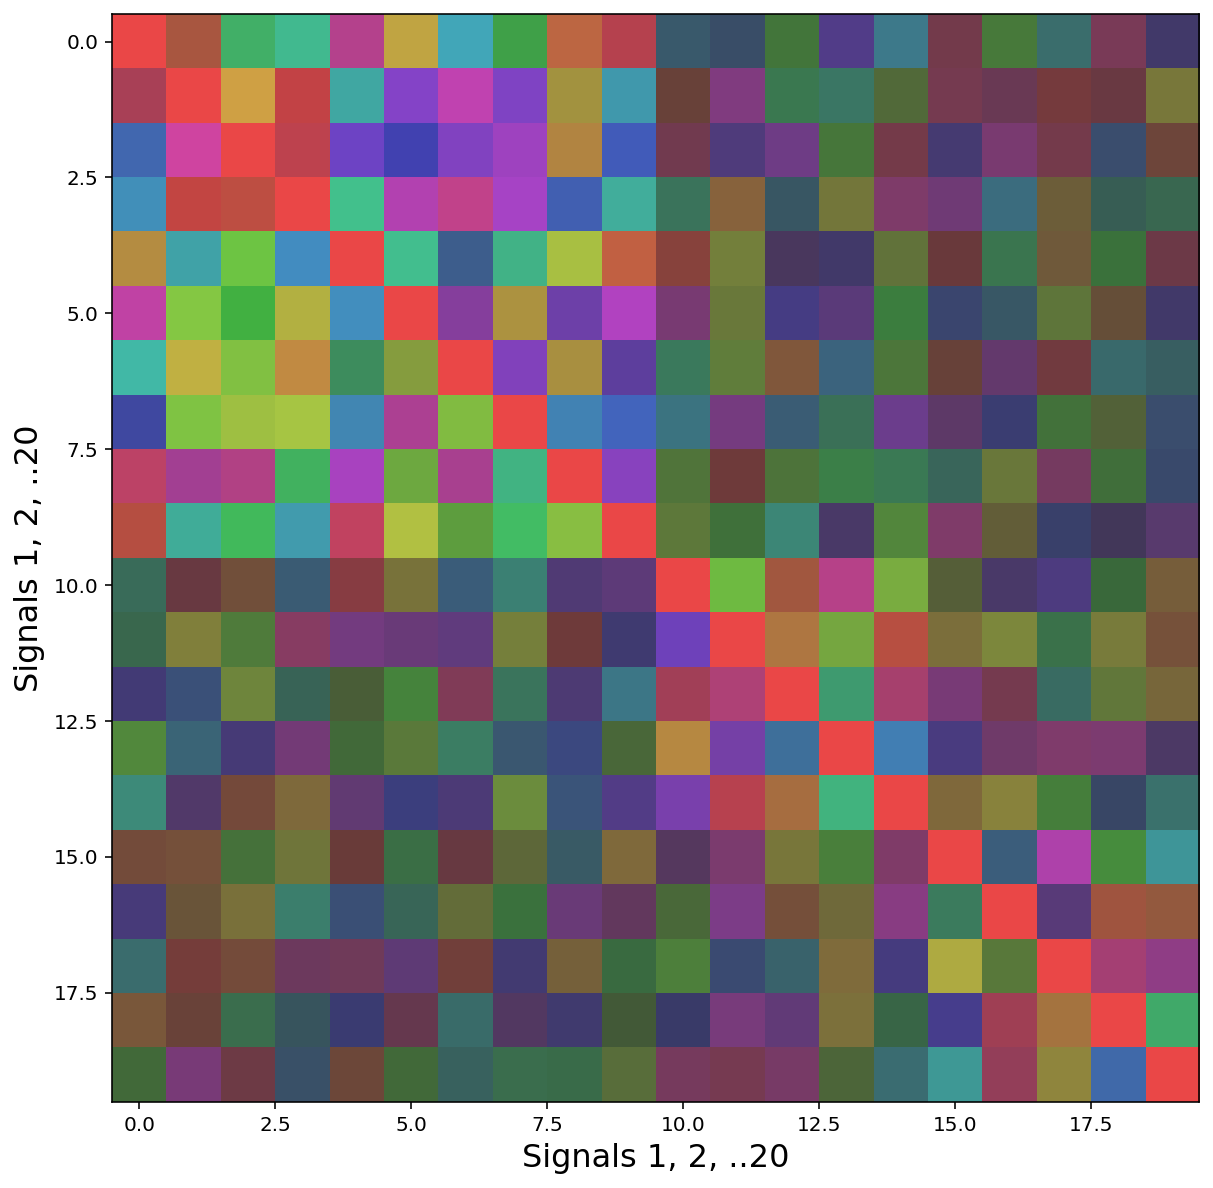

In [7]:
freqs = [10]*10 + [15]*5 + [25]*5
with Parallel(cpu_count()) as pool:
    phases = pool(delayed(run_experiment_phases)((f, "first")) for f in tqdm(freqs, leave=False, position=0, desc="Experiment")) 
    
plot_PLV(phases)

* По полученной картинки видим, 3 ярко выраженных квадрата размера (10 на 10), (5 на 5) и (5 на 5). Это сигналы соответствующие трем разным частотам и PLV посчитанное попарно для них сильно отличается от посчитанного с остальными сигналами. Можно сделать вывод, что разница фаз сигналов с одинаковой частотой много меньше чем чем для сигнала с одной и другой частотой. 

### 3.

Number of windows: 60


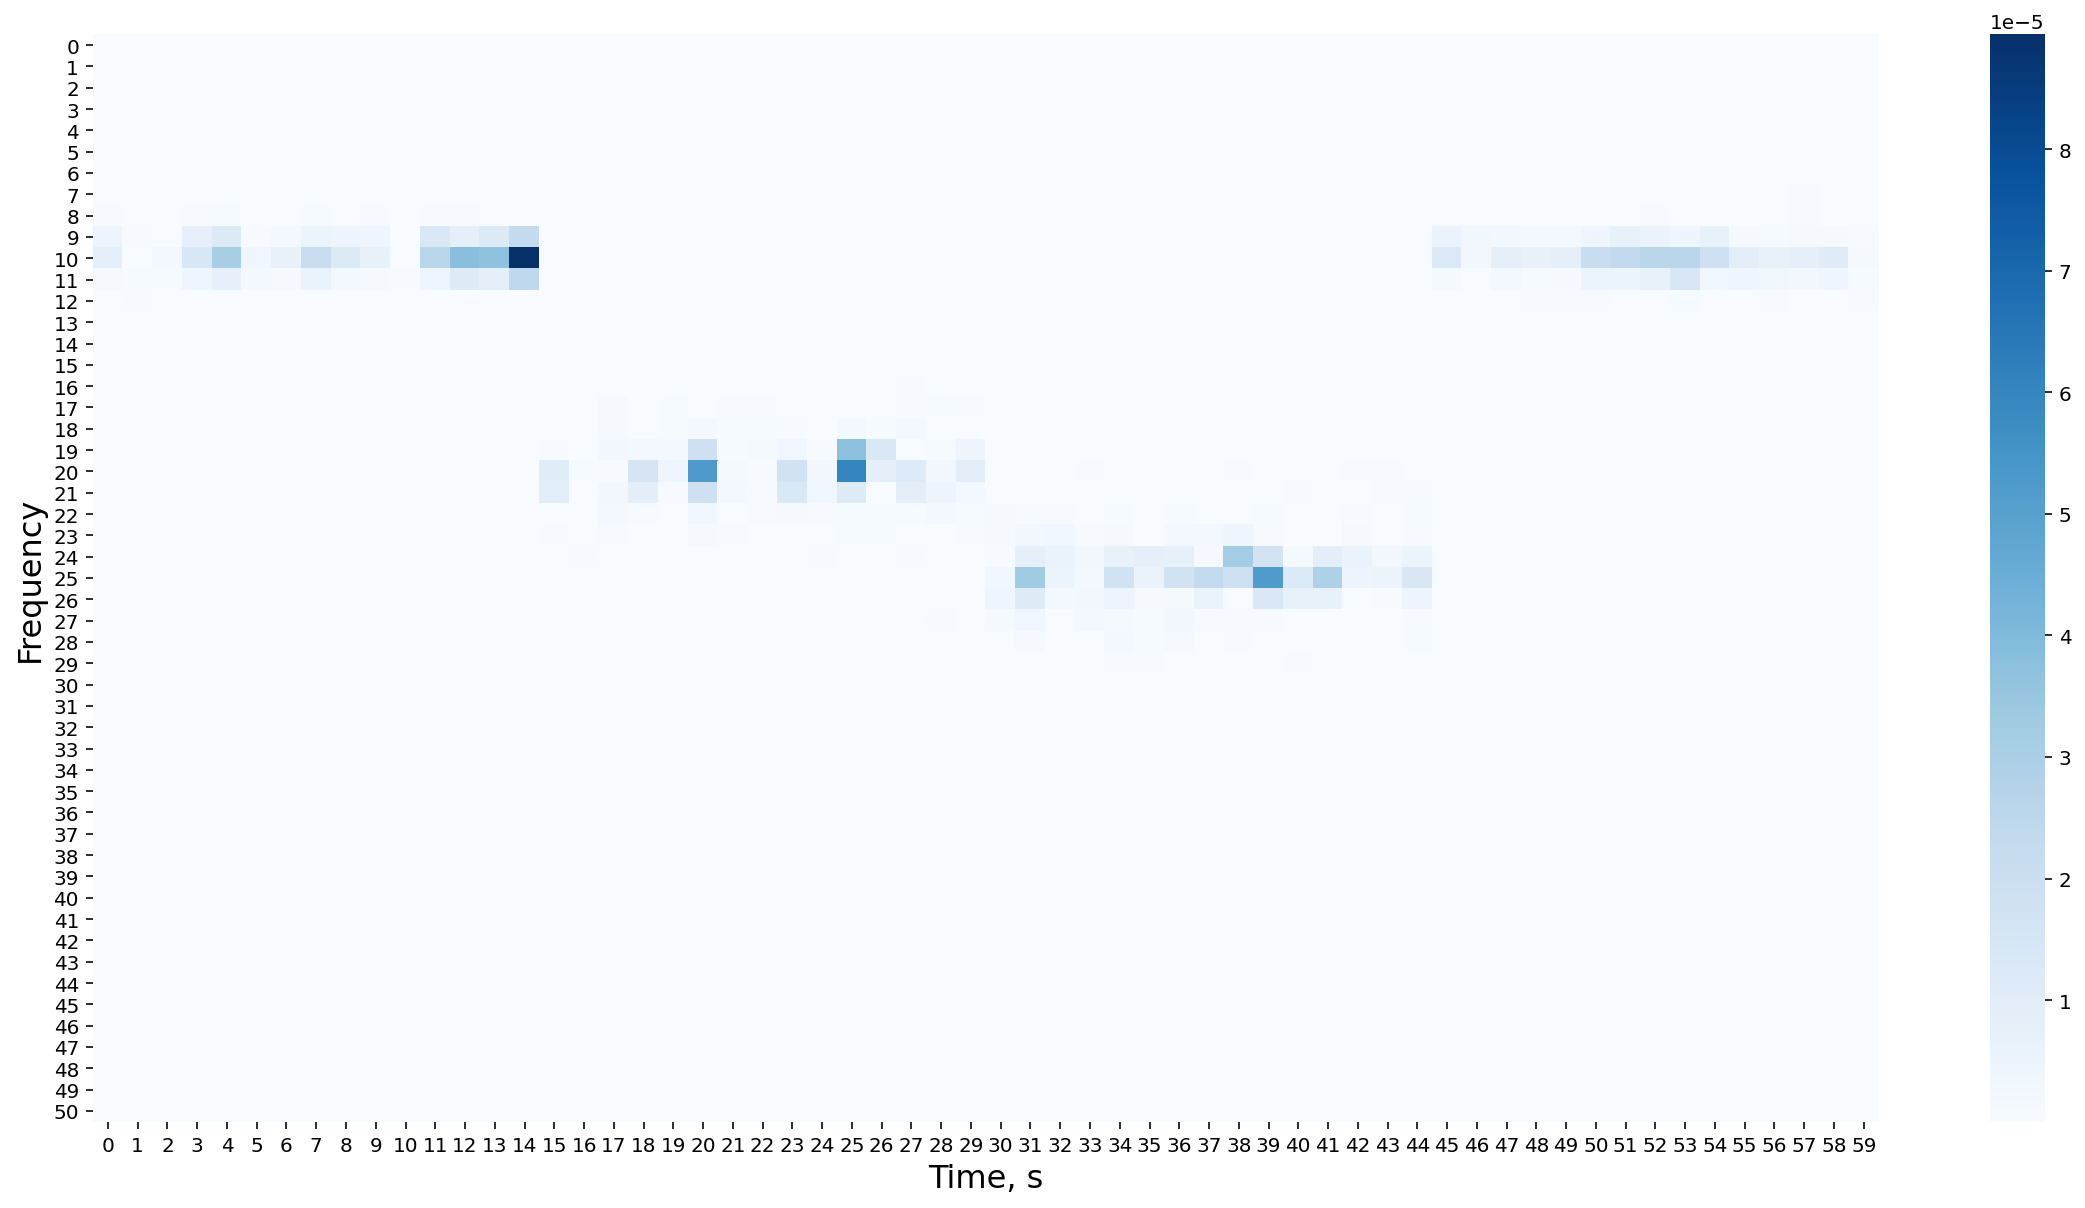

In [12]:
#Get mean signal of the 2-nd experiment:
signal = np.mean([x[2] for x in res], axis=0)
plot_colormap(get_colormap_matrix(signal))

* Данный heatmap прекрасно выражает то, что сигналы были последовательно поданы с частотами 10, 20, 25, 10 (ось Y).